# QiTech Thermostat Controller Challenge
## Scenario
We have a high-mass element A of which we can measure the temperature of.

We have a low-mass element B which we can heat. Both Elements are in contact to each other. Element B can also discapate heat to the environment.

## Goal
Create an algorithm that control the power of the heating element. Your controller have persitent values and a function `control` which takes the measures temperature of element A, the target temperature (constant) and the constant ambient temperature. `dt` is the time delta in seconds (always `1`). 
Only control signal from `0`-`1` have effect. `1` means maximum heating power.

Its your goal to build a generalistic thermostat controller (as we don't know the exact properties ofour real system) that improves core metrics.

## Simulation
We have a simple simulatoin called `TemperatureSimulation` with standard properties that don't change. `SuperTemperatureSimulation` runs many simulations with different properties so we can see how your controller behaves in different situations.

## Metrics
### Mean Error
Mean error calculated after 1800 seconds.
The error is the target temp - measured temp in C.

This tracks the steady state error fo your controller and should be near 0.

## Error STD
Standard deviation (sigma) of the error after 1800 seconds.

This tracks the temperature oscillation and should be near 0.

## Overshoot
The maxmumum overshoot the system produced. Overshoot is the maxmimum measured temperature - target temperature.

overshoot should be minimal.

## Time to reach ±0.5°C
This metric tracks the time your controller needs to reach a stable temperature in seconds.

This metric should also be minimized.

Running single simulation with default parameters...
Simulation Parameters:
Element A (measured element):
- Mass: 1.0 kg
- Specific Heat Capacity: 490 J/(kg·°C)

Element B (heating element):
- Mass: 0.4 kg
- Specific Heat Capacity: 400 J/(kg·°C)

Heat Transfer:
- A-B Contact Area: 0.5 m²
- A-B Heat Transfer Coefficient: 100 W/(m²·°C)
- B-Air Contact Area: 0.5 m²
- B-Air Heat Transfer Coefficient: 10 W/(m²·°C)

Environment:
- Ambient Temperature: 25 °C

Simulation Settings:
- Total Time: 3600 seconds
- Time Step (dt): 1 seconds
Simulation Statistics:
- Mean Error (after 1800s): 0.00 °C
- Error STD (after 1800s): 0.12 °C
- Overshoot Error: 25.00 °C
- Final Element A Temperature: 149.89 °C
- Final Element B Temperature: 149.93 °C
- Maximum A-B Temperature Difference: 10.08 °C
- Time to reach ±0.5°C: 285.00 seconds


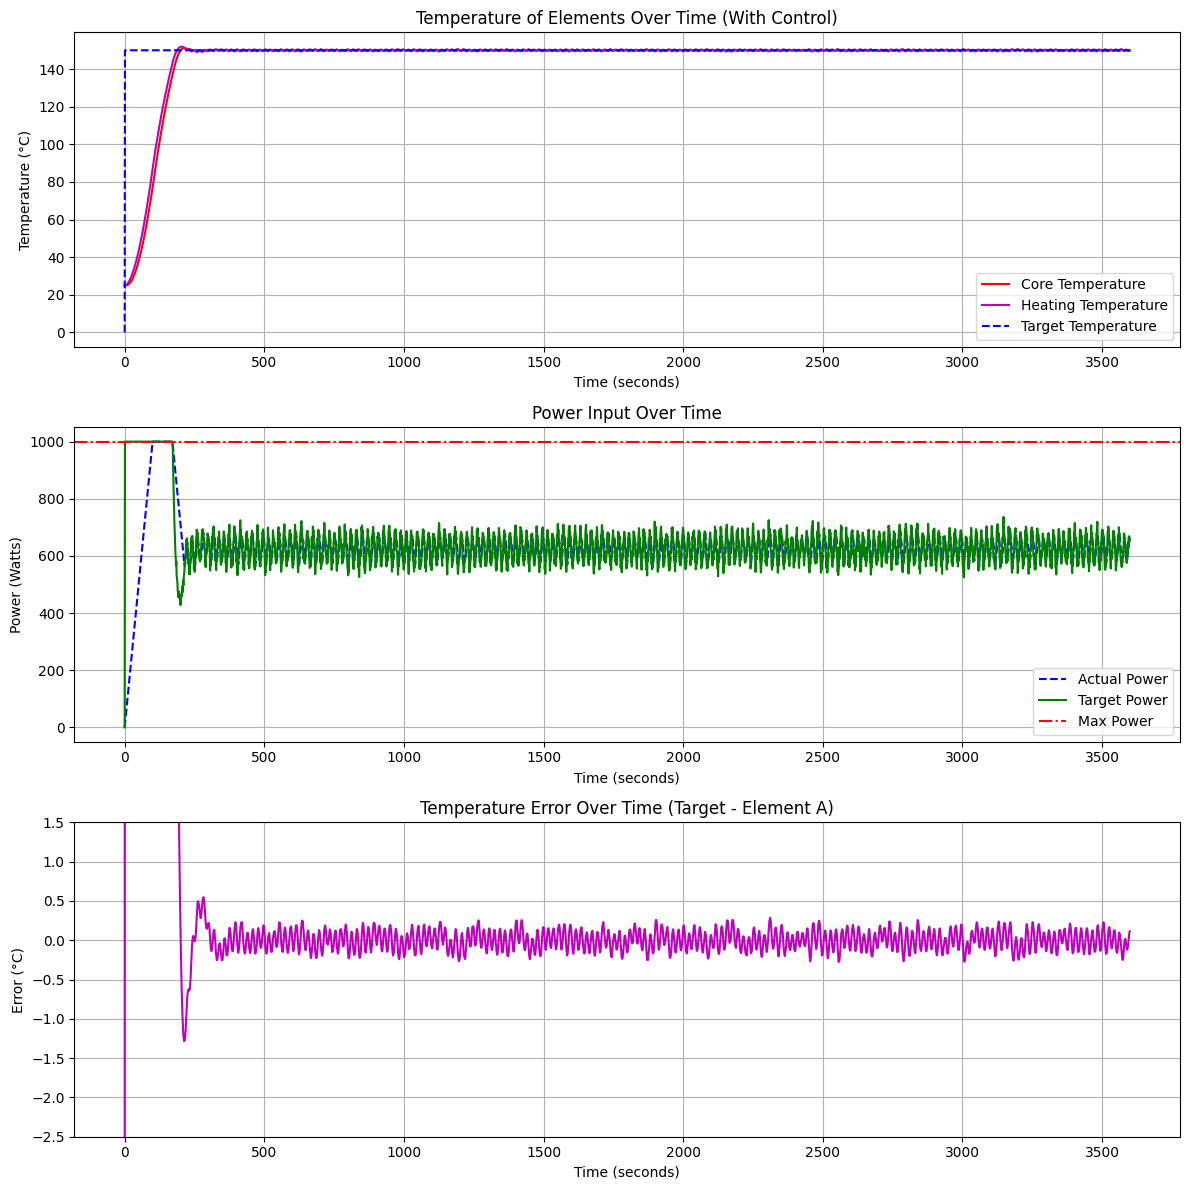

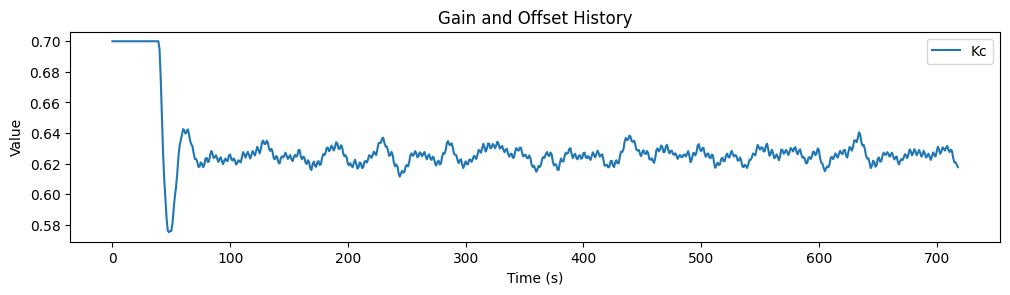

In [1]:
import tempsim

c_history = []
time = []

def squared_keep_negative(x):
    if x < 0:
        return -(x ** 2)
    else:
        return x ** 2

def compute_mean_error(errors):
    """Compute the mean of a list of errors."""
    return squared_keep_negative(sum(errors) / len(errors))


def compute_gradient_c(errors, c_value, delta=1e-3):
    """
    Estimate the gradient of the cost (mean error) with respect to C using finite differences.
    """
    # Calculate current cost
    current_cost = abs(compute_mean_error(errors))

    # The change in C affects all errors roughly equally in this model
    errors_up = [
        error - delta for error in errors
    ]  # Approximation of how C affects errors
    cost_up = abs(compute_mean_error(errors_up))

    # Calculate gradient
    gradient = (cost_up - current_cost) / delta
    return gradient


def create_controller():
    # PDC controller parameters
    Kp = 0.08  # Proportional gain
    Kd = 1.2  # Derivative gain
    Kc = 0.8  # Constant gain - will be adaptive

    # Learning parameters
    learning_rate_c = 0.01

    # Persistent values
    prev_error = 0
    error_history = []
    seconds_counter = 0

    def control(measured_temp, target_temp, ambient_temperature, dt):
        nonlocal prev_error, error_history, seconds_counter, Kc

        # Update time counter
        seconds_counter += dt

        # Calculate error
        error = target_temp - measured_temp

        # Store error in history
        error_history.append(error)

        # Keep only the last 5 seconds of errors
        if len(error_history) > 5:
            error_history.pop(0)

        # Proportional term
        p_term = Kp * error

        # Derivative term
        d_term = Kd * (error - prev_error) / dt if dt > 0 else 0
        prev_error = error

        # Constant term
        c_term = Kc

        # Adjust C value every 5 seconds using gradient descent
        if seconds_counter >= 5:
            # Reset counter
            seconds_counter = 0

            # Perform gradient descent
            gradient = compute_gradient_c(error_history, Kc)

            # Update C value to minimize absolute mean error
            Kc -= learning_rate_c * gradient

            # Keep C within reasonable bounds
            Kc = max(0, min(Kc, 0.7))

            # Optional: Log the changes
            c_history.append(Kc)
            time.append(time[-1] + dt if time else 0)

        # Calculate control signal (sum of P, D, and C terms)
        control_signal = p_term + d_term + c_term

        return control_signal

    return control


# Create controller
pid_controller = create_controller()

# Run a single simulation first to see baseline performance
print("Running single simulation with default parameters...")
sim = tempsim.TemperatureSimulation(pid_controller)
sim.run_simulation()
sim.print_parameters()
sim.print_statistics()
sim.plot_results()


# plot gain and offset history
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, c_history, label="Kc")
plt.title('Gain and Offset History')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()
plt.show()


Running multiple randomized simulations...
Running simulation 1000/1000...
===== AGGREGATE SIMULATION STATISTICS =====
Based on 1000 randomized simulations

Mean Error (after 1800s):
  Mean: 0.16 °C
  Std Dev: 0.77 °C

Error Standard Deviation (after 1800s):
  Mean: 0.06 °C
  Std Dev: 0.17 °C

Overshoot Error:
  Mean: 25.16 °C
  Std Dev: 3.09 °C

Max Temperature Difference between Elements A and B:
  Mean: 19.27 °C
  Std Dev: 5.62 °C

Time to reach ±0.5°C for 600s:
  Mean: 410.35 seconds
  Std Dev: 85.82 seconds
  Success Rate: 91.4%


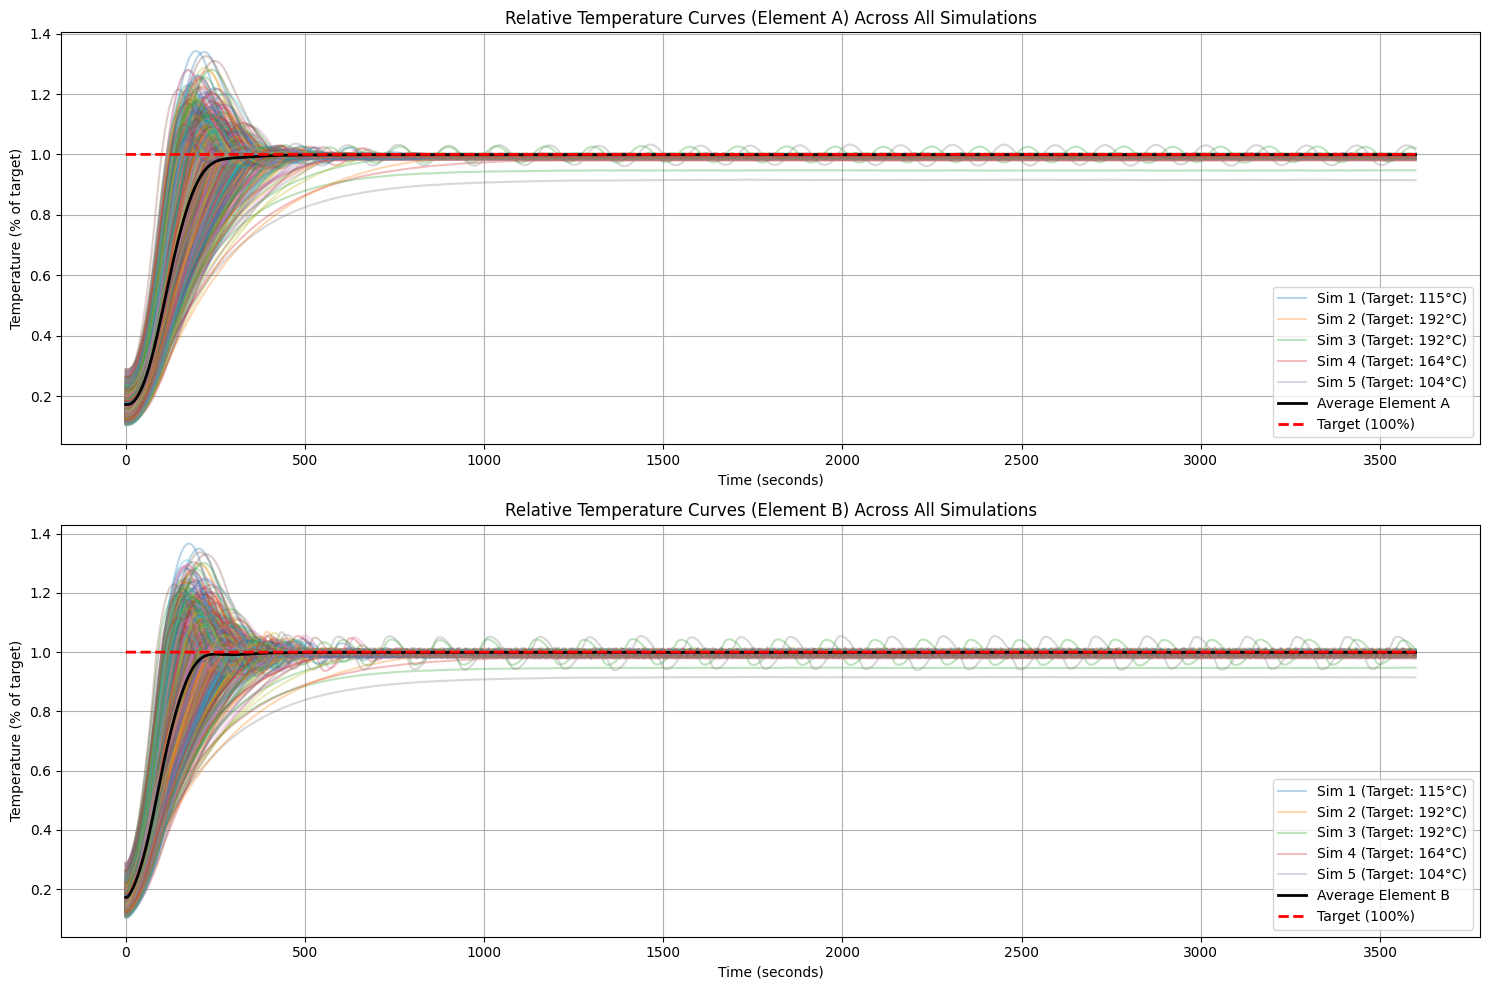

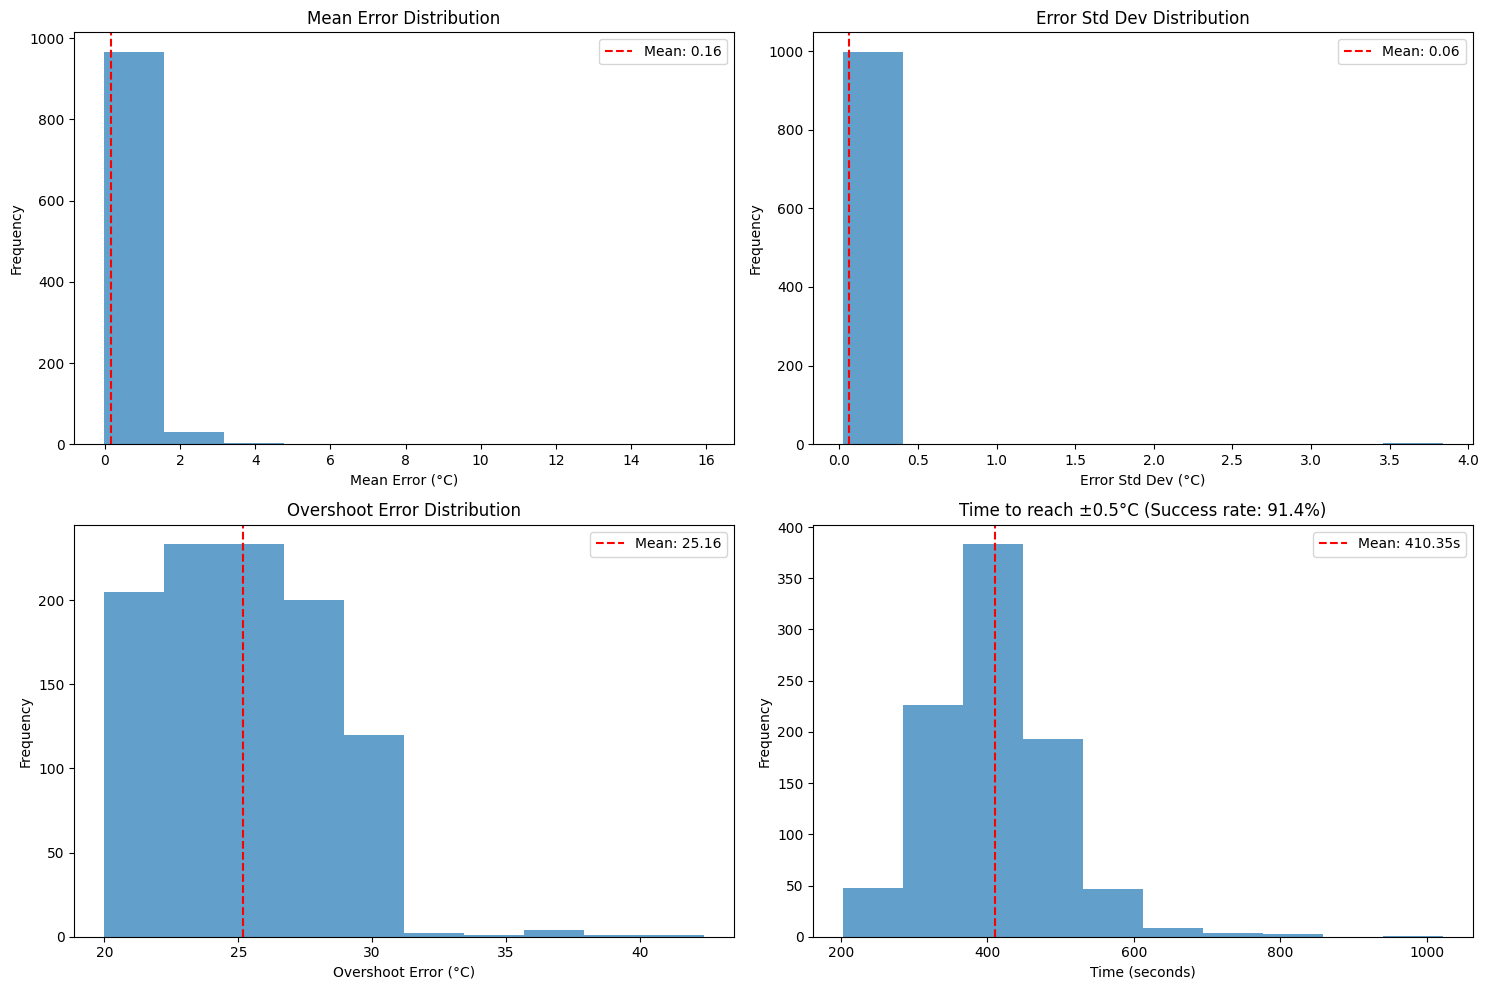

In [2]:
# Run multiple randomized simulations
print("\nRunning multiple randomized simulations...")
super_sim = tempsim.SuperTemperatureSimulation(
    control_function=pid_controller,
    n_simulations=1000,
)

# Run all simulations
super_sim.run_simulations()

# Print aggregate statistics
super_sim.print_aggregate_statistics()

# Visualize results
super_sim.plot_temperature_comparison()
super_sim.plot_error_distribution()